# Project Setup

In [1]:
import urllib.request
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration

## Load Dataset

In [2]:
df_vt = pd.read_csv('./data/VT-clean.csv.gz', compression='gzip', low_memory=False)

In [3]:
df_vt.head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,driver_race,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id
0,VT-2010-00001,VT,2010-07-01,00:10,East Montpelier,Washington County,50023.0,COUNTY RD,MIDDLESEX VSP,M,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Citation,False,-1.562157e+09
1,VT-2010-00002,VT,2010-07-01,00:10,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
2,VT-2010-00003,VT,2010-07-01,00:10,NaN,NaN,NaN,COUNTY RD; Fitch Road,MIDDLESEX VSP,F,...,White,Externally Generated Stop,Other,False,No Search Conducted,NaN,False,Arrest for Violation,True,-1.562157e+09
3,VT-2010-00004,VT,2010-07-01,00:11,Whiting,Addison County,50001.0,N MAIN ST,NEW HAVEN VSP,F,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Arrest for Violation,True,-3.126844e+08
4,VT-2010-00005,VT,2010-07-01,00:35,Hardwick,Caledonia County,50005.0,i91 nb mm 62,ROYALTON VSP,M,...,White,Moving Violation,Moving violation,False,No Search Conducted,NaN,False,Written Warning,False,9.225661e+08


In [5]:
df_vt.columns

Index(['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome',
       'is_arrested', 'officer_id', 'year'],
      dtype='object')

## Clean Dataset

In [6]:
df_vt.count()

id                       283285
state                    283285
stop_date                283285
stop_time                283285
location_raw             282591
county_name              282580
county_fips              282580
fine_grained_location    282938
police_department        283285
driver_gender            281573
driver_age_raw           282114
driver_age               281999
driver_race_raw          279301
driver_race              278468
violation_raw            281107
violation                281107
search_conducted         283285
search_type_raw          281045
search_type                3419
contraband_found         283251
stop_outcome             280960
is_arrested              283285
officer_id               283273
year                     283285
dtype: int64

In [7]:
# Fill missing search type values with placeholder
df_vt['search_type'].fillna('N/A', inplace=True)

# Drop rows with missing values
df_vt.dropna(inplace=True)

In [8]:
df_vt.count()

id                       273181
state                    273181
stop_date                273181
stop_time                273181
location_raw             273181
county_name              273181
county_fips              273181
fine_grained_location    273181
police_department        273181
driver_gender            273181
driver_age_raw           273181
driver_age               273181
driver_race_raw          273181
driver_race              273181
violation_raw            273181
violation                273181
search_conducted         273181
search_type_raw          273181
search_type              273181
contraband_found         273181
stop_outcome             273181
is_arrested              273181
officer_id               273181
year                     273181
dtype: int64

## Explore Data

In [9]:
df_vt['county_name'].value_counts()

Windham County       37715
Windsor County       36464
Chittenden County    24815
Orange County        24679
Washington County    24633
Rutland County       22885
Addison County       22813
Bennington County    22250
Franklin County      19715
Caledonia County     16505
Orleans County       10344
Lamoille County       8604
Essex County          1239
Grand Isle County      520
Name: county_name, dtype: int64

In [21]:
df_vt['violation'].value_counts()

Moving violation      212100
Equipment              50600
Other                   9768
DUI                      711
Other (non-mapped)         2
Name: violation, dtype: int64

In [44]:
df_vt.groupby(['driver_race','violation']).apply(compute_violation_and_outcome_stats)

arrest_ratio  n_arrests  n_citations  \
driver_race violation                                                    
Asian       DUI                0      0.200000          2            2   
            Equipment          0      0.006270          2           37   
            Moving violation   0      0.005563         17         1647   
            Other              0      0.016393          1           28   
Black       DUI                0      0.200000          2            1   
            Equipment          0      0.029181         26          156   
            Moving violation   0      0.016052         71         2110   
            Other              0      0.048583         12          161   
Hispanic    DUI                0      0.200000          2            6   
            Equipment          0      0.023560          9           59   
            Moving violation   0      0.012422         26         1062   
            Other              0      0.064935          5           41   
Other       Equipment          0      0.069767          3            8   
            Moving violation   0      0.014493          3          117   
            Other              0      0.076923          1            6   
White       DUI                0      0.192364        131          172   
            Equipment          0      0.012233        599         7736   
            Moving violation   0      0.008635       1747        84797   
            Other              0      0.058378        547         5254   
            Other (non-mapped) 0      0.000000          0            1   

                                  n_total  n_warnings  warning_citation_ratio  
driver_race violation                                                          
Asian       DUI                0       10           6                0.333333  
            Equipment          0      319         280                0.132143  
            Moving violation   0     3056        1392                1.183190  
            Other              0       61          32                0.875000  
Black       DUI                0       10           7                0.142857  
            Equipment          0      891         707                0.220651  
            Moving violation   0     4423        2239                0.942385  
            Other              0      247          73                2.205479  
Hispanic    DUI                0       10           2                3.000000  
            Equipment          0      382         314                0.187898  
            Moving violation   0     2093        1003                1.058824  
            Other              0       77          30                1.366667  
Other       Equipment          0       43          32                0.250000  
            Moving violation   0      207          87                1.344828  
            Other              0       13           6                1.000000  
White       DUI                0      681         378                0.455026  
            Equipment          0    48965       40612                0.190486  
            Moving violation   0   202321      115729                0.732720  
            Other              0     9370        3558                1.476672  
            Other (non-mapped) 0        2           1                1.000000

In [43]:
df_vt.groupby(['driver_race']).apply(compute_violation_and_outcome_stats)

,,arrest_ratio,n_arrests,n_citations,n_total,n_warnings,warning_citation_ratio
driver_race,,,,,,,
Asian,0,0.006384,22,1714,3446,1710,1.002339
Black,0,0.019925,111,2428,5571,3026,0.802379
Hispanic,0,0.016393,42,1168,2562,1349,0.865827
Other,0,0.026616,7,131,263,125,1.048000
White,0,0.011571,3024,97960,261339,160278,0.611188


In [42]:
# Analyze for each race - distribution of stop types.  distribution of stop outcome by type.

def compute_violation_and_outcome_stats(df):
    """Compute the search rate and hit rate"""
    n_total = len(df)
    n_warnings = len(df[df['stop_outcome'] == 'Written Warning'])
    n_citations = len(df[df['stop_outcome'] == 'Citation'])
    n_arrests = len(df[df['stop_outcome'] == 'Arrest for Violation'])
    warning_citation_ratio = n_citations / n_warnings
    arrest_ratio = n_arrests / n_total
    
    return(pd.DataFrame(data = { 
        'n_total': n_total,
        'n_warnings': n_warnings,
        'n_citations': n_citations,
        'n_arrests': n_arrests,
        'warning_citation_ratio': warning_citation_ratio,
        'arrest_ratio': arrest_ratio
    }, index=[0]))

In [11]:
df_vt['stop_outcome'].value_counts()

Written Warning         166488
Citation                103401
Arrest for Violation      3206
Warrant Arrest              76
Verbal Warning              10
Name: stop_outcome, dtype: int64

In [12]:
df_vt.groupby('driver_gender').count()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_age_raw,...,violation_raw,violation,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,year
driver_gender,,,,,,,,,,,,,,,,,,,,,
F,99111,99111,99111,99111,99111,99111,99111,99111,99111,99111,...,99111,99111,99111,99111,99111,99111,99111,99111,99111,99111
M,174070,174070,174070,174070,174070,174070,174070,174070,174070,174070,...,174070,174070,174070,174070,174070,174070,174070,174070,174070,174070


In [66]:
df_vt['driver_gender'].value_counts()

M    179678
F    101895
Name: driver_gender, dtype: int64

In [67]:
df_vt['driver_race'].value_counts()

White       266216
Black         5741
Asian         3607
Hispanic      2625
Other          279
Name: driver_race, dtype: int64

# Analyze Data

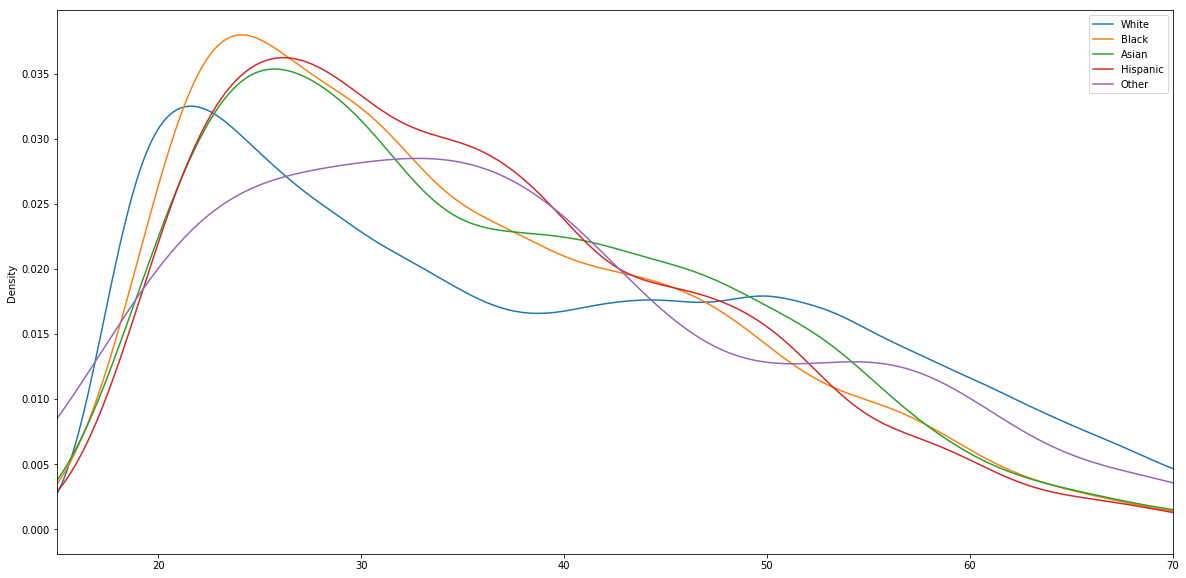

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlim(15, 70)
for race in df_vt['driver_race'].unique():
    s = df_vt[df_vt['driver_race'] == race]['driver_age']
    s.plot.kde(ax=ax, label=race)
ax.legend()

In [72]:
fig.savefig('race_age_dist.png', bbox_inches='tight')

In [74]:
def compute_search_stats(df):
    """Compute the search rate and hit rate"""
    search_conducted = df['search_conducted']
    contraband_found = df['contraband_found']
    n_stops     = len(search_conducted)
    n_searches  = sum(search_conducted)
    n_hits      = sum(contraband_found)
    
    if (n_stops) < 50:
        search_rate = None
    else:
        search_rate = n_searches / n_stops
    
    if (n_searches) < 5:
        hit_rate = None
    else:
        hit_rate = n_hits / n_searches
    
    return(pd.DataFrame(data = { 
        'n_stops': n_stops,
        'n_searches': n_searches,
        'n_hits': n_hits,
        'search_rate': search_rate,
        'hit_rate': hit_rate
    }, index=[0]))

In [75]:
compute_search_stats(df_vt)

,hit_rate,n_hits,n_searches,n_stops,search_rate
0,0.796262,2599,3264,273181,0.011948


In [16]:
df_vt.groupby('driver_gender').apply(compute_search_stats)

,,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_gender,,,,,,
F,0,0.788820,508,644,99111,0.006498
M,0,0.798092,2091,2620,174070,0.015051


In [17]:
df_vt.groupby('driver_race').apply(compute_search_stats)

,,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,,
Asian,0,0.785714,22,28,3446,0.008125
Black,0,0.686620,195,284,5571,0.050978
Hispanic,0,0.644231,67,104,2562,0.040593
Other,0,0.600000,6,10,263,0.038023
White,0,0.813601,2309,2838,261339,0.010859


In [18]:
age_groups = pd.cut(df_vt["driver_age"], np.arange(15, 70, 5))
age_aggregation = df_vt.groupby(age_groups).apply(compute_search_stats)
age_aggregation

,,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_age,,,,,,
"(15, 20]",0,0.846954,570,673,27443,0.024524
"(20, 25]",0,0.837488,840,1003,43310,0.023159
"(25, 30]",0,0.788800,493,625,34794,0.017963
"(30, 35]",0,0.766756,286,373,27784,0.013425
"(35, 40]",0,0.744186,160,215,23241,0.009251
"(40, 45]",0,0.692913,88,127,24083,0.005273
"(45, 50]",0,0.575472,61,106,24117,0.004395
"(50, 55]",0,0.697368,53,76,22532,0.003373
"(55, 60]",0,0.833333,30,36,17522,0.002055


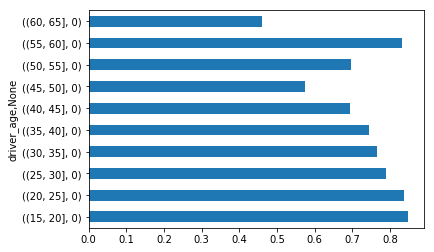

In [19]:
age_aggregation['hit_rate'].plot.barh()

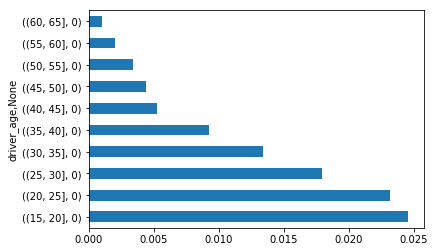

In [20]:
age_aggregation['search_rate'].plot.barh()

In [21]:
# Compare search rates between races and genders
race_gender_agg = df_vt.groupby(['driver_race', 'driver_gender']).apply(compute_search_stats)

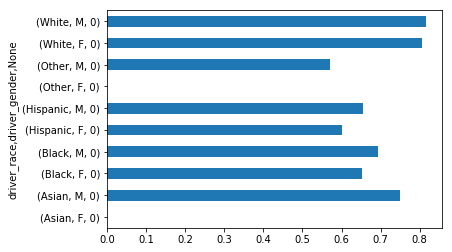

In [22]:
race_gender_agg['hit_rate'].plot.barh()

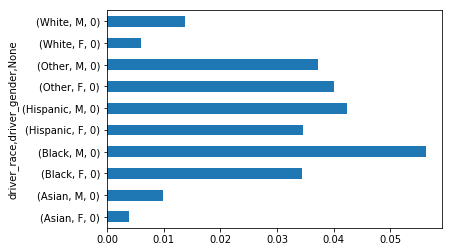

In [23]:
race_gender_agg['search_rate'].plot.barh()

In [68]:
def visualize_search_stats_by_county(df):
    """Generate a scatter plot of search rate vs. hit rate by race and county"""
    race_location_agg = df.groupby(['county_name','driver_race']).apply(compute_search_stats)

    fig, ax = plt.subplots()
    for c, frame in race_location_agg.groupby('driver_race'):
        ax.scatter(x=frame['hit_rate'], y=frame['search_rate'], label=c)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
              ncol=5, fancybox=True)
    ax.set_xlabel('Hit Rate')
    ax.set_ylabel('Search Rate')

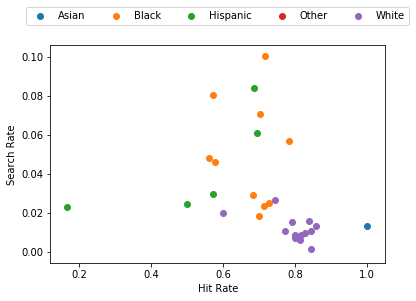

In [69]:
visualize_search_stats_by_county(df_vt)

# Wisconsin

In [78]:
fields = ['county_name', 'driver_race', 'search_conducted', 'contraband_found']

In [90]:
df_wi = pd.read_csv('./data/WI-clean.csv.gz', compression='gzip', low_memory=False, usecols=fields)

In [91]:
df_wi.dropna(inplace=True)

In [81]:
# visualize_county_hit_rates(df_wi)

In [94]:
df_wi.groupby('driver_race').apply(compute_search_stats)

,,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,,
Asian,0,0.470817,121,257,24577,0.010457
Black,0,0.477574,1299,2720,56050,0.048528
Hispanic,0,0.415741,449,1080,35210,0.030673
Other,0,0.509709,210,412,11361,0.036264
White,0,0.526300,5103,9696,778227,0.012459


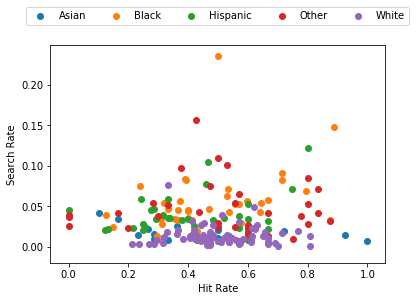

In [82]:
visualize_search_stats_by_county(df_wi)

In [92]:
#compute_white_vs_minority_hit_rate(df_wi)

# MA

In [83]:
df_ma = pd.read_csv('./data/MA-clean.csv.gz', compression='gzip', low_memory=False, usecols=fields)

In [84]:
df_ma.dropna(inplace=True)

In [89]:
df_ma.groupby('driver_race').apply(compute_search_stats)

,,hit_rate,n_hits,n_searches,n_stops,search_rate
driver_race,,,,,,
Asian,0,0.331169,357,1078,101942,0.010575
Black,0,0.487150,4170,8560,350498,0.024422
Hispanic,0,0.449502,5007,11139,337782,0.032977
Other,0,0.358442,276,770,75370,0.010216
White,0,0.523037,18220,34835,2527393,0.013783


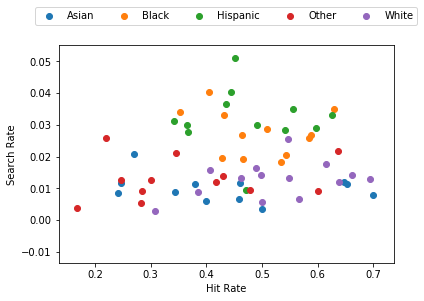

In [86]:
# visualize_county_hit_rates(df_ma)

In [87]:
# compute_white_vs_minority_hit_rate(df_ma)

In [233]:
df_ma_tmp = df_ma.copy()
df_ma_tmp['is_white'] = df_ma_tmp['driver_race'] == 'White'
race_location_agg = df_ma_tmp.groupby(['county_name','is_white']).apply(compute_hit_rate)

In [240]:
race_location_agg.iloc[0]

hit_rate          0.348592
n_hits           99.000000
n_searches      284.000000
n_stops        9750.000000
search_rate       0.029128
Name: (Barnstable County, False, 0), dtype: float64

In [335]:
def compute_bad_search_rates(df):
    """Compute what percentage of stops will result in a search where no contraband is found"""
    df_tmp = df.copy()
    df_tmp['is_white'] = df_tmp['driver_race'] == 'White'
    race_location_agg = df_tmp.groupby(['county_name','is_white']).apply(compute_hit_rate)    
    county_dict = {}
    for index in range(0, len(race_location_agg), 2):
        non_white_row = race_location_agg.iloc[index]
        white_row = race_location_agg.iloc[index+1]
        county = race_location_agg.iloc[index].name[0]

        white_bad_search_rate = (white_row.n_searches - white_row.n_hits) / white_row.n_stops
        non_white_bad_search_rate = (non_white_row.n_searches - non_white_row.n_hits) / non_white_row.n_stops

        county_dict[county] = dict(
            bias = non_white_bad_search_rate/ white_bad_search_rate,
            white = white_bad_search_rate,
            non_white = non_white_bad_search_rate)
    return county_dict

In [336]:
ma_county_data = compute_bad_search_rates(df_ma)

In [339]:
ma_county_df = pd.DataFrame.from_dict(ma_county_data, orient='index')

In [342]:
ma_county_df.to_csv('ma_county_stats.csv')